In [1]:
# Module
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# K-Means(2D) - 각 군집을 계층적으로 여러번 군집화 시키기
참고 : https://medium.com/@nsh235482/k-means-clustering-6ab85a2a32ad

### API 데이터 정리
>#### acousticness 
>> 트랙의 음향에서 어쿠스틱 요소 여부에 대해 0.0에서 1.0까지의 특성을 측정. 1.0은 트랙이 어쿠스틱적이라는 측정.     

> #### danceability  
>> 곡이 가지는 템포, 리듬의 안정성, 박자 강도 및 전반적인 규칙성을 포함한 음악 요소의 조합에 따라 춤에 적합한 트랙을 설명합니다.    
0.0 부터 1.0까지의 값이 존재하고, 1.0은 가장 무용에 적합합니다.         

>#### duration_ms  : 밀리 초 단위의 트랙 지속 시간.      

>#### energy      
>> 곡이 얼마나 강렬하고 활동적인지를 측정한 값. 0.0에서 1.0까지 값이 존재.     
일반적으로 활기찬 트랙은 빠르고 시끄럽습니다.     
예를 들어, 데스 메탈은 높은 에너지를 가지고있는 반면 바흐 서곡은 낮은 점수를 얻습니다.     
이 속성에 기여하는 지각 특징은 동적 범위,인지 된 소리 크기, 음색, 시작 속도 및 일반 엔트로피를 포함합니다.     
이 기능의 값 분포는 다음과 같습니다.    

>#### instrumentalness   
>> 트랙에 보컬이 없는지 여부를 예측합니다.    
"우"와 "아"소리는 문맥에서 판단도구로 취급됩니다.     
Instrumentalness 값이 1.0에 가까울수록 트랙에 보컬 콘텐츠가 포함되지 않을 확률이 높아집니다.      
0.5 이상의 값은 악기 트랙을 나타 내기위한 것이지만 값이 1.0에 가까워 질수록 보컬트랙이 포함될 가능성이 높습니다.     
  
>#### key     
>> 음악의 전체적인 키를 표시합니다.    
예 : 0 = C, 1 = C # / D ♭, 2 = D 등. 키가 발견되지 않으면 값은 -1입니다.    

>#### liveness      
>> 0.8보다 큰 값은 트랙이 라이브 트랙일 가능성이 큽니다.   

>#### loudness      
>> 트랙의 전체 소리 크기 (데시벨 (dB))입니다.     
음량 값은 전체 트랙에서 평균화되며 트랙의 상대적 음량을 비교하는 데 유용합니다.     
값 범위는 -60에서 0 db 사이입니다.    

>#### mode        

>#### speechiness 
>> Speechiness는 트랙에서 말한 단어의 존재를 감지합니다.    
독점적으로 말하기와 같은 녹음 (예 : 토크쇼, 오디오 북,시)은 1.0에 가까워집니다.    
0.66 이상의 값은 전적으로 음성 단어로 만들어진 트랙을 나타냅니다.   
0.33에서 0.66 사이의 값은 랩 음악과 같은 경우를 포함하여 섹션 또는 계층으로 음악과 음성을 모두 포함 할 수있는 트랙을 나타냅니다.   
0.33 미만의 값은 음악 및 기타 비언 연적 트랙을 나타낼 가능성이 가장 높습니다.     
 
>#### tempo 
>> 분당 비트 수 (BPM)로 트랙의 전체 예상 템포.   
음악 용어에서 템포는 주어진 곡의 속도 또는 속도이며 평균 비트 지속 시간에서 직접 파생됩니다.    

>#### time_signature 
>> 박자

>#### valence        
>> 트랙에 의해 전달되는 음악적 양립성을 나타내는 0.0에서 1.0까지의 측정 값입니다.     
높은 원자가를 가진 트랙은 긍정적 (예 : 행복, 쾌활, 행복),    
낮은 원자가의 트랙은 더 부정적 (예 : 슬프고 우울, 분노)합니다.    

In [3]:
# 데이터 불러오기 API data
songs = pd.read_csv('./data/SpotifyAudioFeatures2000_2018.csv')

In [4]:
# 데이터 확인
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169299 entries, 0 to 169298
Data columns (total 22 columns):
Unnamed: 0          169299 non-null int64
Unnamed: 0.1        169299 non-null int64
artist_name         169299 non-null object
track_name          169299 non-null object
track_id            169299 non-null object
popularity          169299 non-null int64
url                 169299 non-null object
images              169264 non-null object
date                169299 non-null object
acousticness        169299 non-null float64
danceability        169299 non-null float64
duration_ms         169299 non-null int64
energy              169299 non-null float64
instrumentalness    169299 non-null float64
key                 169299 non-null int64
liveness            169299 non-null float64
loudness            169299 non-null float64
mode                169299 non-null int64
speechiness         169299 non-null float64
tempo               169299 non-null float64
time_signature      169299 

In [5]:
del songs['Unnamed: 0']
del songs['Unnamed: 0.1']

#### 표준화

In [6]:
# 기초 통계량 확인
songs.describe()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,169299.000000,169299.000000,169299.000000,1.692990e+05,169299.000000,169299.000000,169299.000000,169299.000000,169299.000000,169299.000000,169299.000000,169299.000000,169299.000000,169299.000000
mean,40.418750,0.298974,0.562309,2.362045e+05,0.626488,0.124892,5.257645,0.206260,-8.097425,0.668002,0.096151,120.250754,3.892829,0.481786
std,11.893513,0.322394,0.178118,1.100092e+05,0.247669,0.281089,3.558541,0.183229,4.915052,0.470932,0.122897,30.722586,0.442913,0.258444
min,16.000000,0.000000,0.000000,7.229000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,0.019400,0.447000,1.899470e+05,0.465000,0.000000,2.000000,0.097000,-9.564000,0.000000,0.035000,95.751500,4.000000,0.273000
50%,39.000000,0.157000,0.572000,2.243460e+05,0.664000,0.000019,5.000000,0.129000,-6.796000,1.000000,0.048400,119.455000,4.000000,0.472000
75%,48.000000,0.542000,0.693000,2.649000e+05,0.830000,0.012700,8.000000,0.261000,-5.015000,1.000000,0.096500,140.035000,4.000000,0.687000
max,98.000000,0.996000,0.987000,5.403500e+06,1.000000,1.000000,11.000000,1.000000,2.039000,1.000000,0.965000,232.690000,5.000000,1.000000


In [7]:
# 연속변수로 구성된 컬럼만 선택하여 데이터프레임 만들기
target_col = ['popularity','duration_ms','key','acousticness','danceability','energy','instrumentalness',
              'liveness','loudness','speechiness','time_signature','tempo','valence']
df = songs[target_col]

# 표준화 필요한 컬럼 
# 판단1 : popularity, duration_ms, key, loudness, tempo,time_signature (0에서 1 사이가 아닌 것 모두 표준화)

# 판단1
cols = ['popularity', 'duration_ms', 'key', 'loudness', 'tempo','time_signature']

# 판단1 표준화
data = songs[cols]
standardized_data = MinMaxScaler().fit_transform(data)

# 표준화 칼럼 재생산
df = pd.DataFrame(standardized_data)
df1 = df.rename(columns={0: 'popularity', 1: 'duration_ms', 2: 'key', 3: 'loudness', 4: 'tempo', 5: 'time_signature'})

# 데이터 합치기
cols_2 = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness',
          'valence']
df2 = songs[cols_2]

# int, float 컬럼 중 표준화 안 해도 되는 컬럼과 표준화한 컬럼 합치기
songs_1 = pd.concat([df1, df2], axis=1)

In [8]:
songs_1.head()

,popularity,duration_ms,key,loudness,tempo,time_signature,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence
0,0.817073,0.038861,0.272727,0.863860,0.452344,0.8,0.01030,0.542,0.853,0.000000,0.1080,0.0498,0.370
1,0.756098,0.042011,1.000000,0.875127,0.425502,0.8,0.00664,0.545,0.865,0.000011,0.1680,0.0286,0.543
2,0.756098,0.051326,0.454545,0.898048,0.449113,0.8,0.03390,0.950,0.665,0.000000,0.0453,0.0610,0.760
3,0.743902,0.048789,0.363636,0.871291,0.408036,0.8,0.14200,0.843,0.805,0.000000,0.0771,0.2690,0.615
4,0.792683,0.048097,1.000000,0.850642,0.745047,0.8,0.00239,0.429,0.661,0.000130,0.2340,0.0281,0.285


In [9]:
# 키 값은 이미 군집화가 되어 있는 것과 마찬가지
songs_1['key'].unique()

array([0.27272727, 1.        , 0.45454545, 0.36363636, 0.72727273,
       0.63636364, 0.09090909, 0.90909091, 0.        , 0.54545455,
       0.18181818, 0.81818182])

# MBTI 방식 군집화

In [10]:
# 클러스터링 할 칼럼들 정
songs_1.head(2)
# 계층 선택1 - speechiness bpm 에 따라 음악과 음악 아닌것이 나뉠 것!
hierarchy1 = songs_1[['popularity']]
hierarchy2 = songs_1[['loudness']]
hierarchy3 = songs_1[['tempo']]
hierarchy4 = songs_1[['time_signature']]
hierarchy5 = songs_1[['acousticness']]
hierarchy6 = songs_1[['danceability']]
hierarchy7 = songs_1[['energy']]
hierarchy8 = songs_1[['instrumentalness']]
hierarchy9 = songs_1[['liveness']]
hierarchy10 = songs_1[['speechiness']]
hierarchy11 = songs_1[['valence']]
hierarchy12 = songs_1[['key']]

#### 1 popularity
곡의 인기도

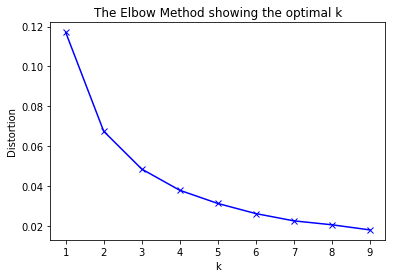

In [10]:
# 최적의 클러스터 갯수 찾기: Elbow Method
distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(hierarchy1)
    kmeanModel.fit(hierarchy1)
    distortions.append(sum(np.min(cdist(hierarchy1, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / hierarchy1.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [11]:
# 최적의 클러스터 갯수 찾기: Silhouette Coefficient(계수가 가장 높은 것이 최적 클러스터 갯수)
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(hierarchy1)
    label = kmeans.labels_
    sil_coeff = silhouette_score(hierarchy1, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    
print("""
--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.5751837615730765
For n_clusters=3, The Silhouette Coefficient is 0.5509968511379394
For n_clusters=4, The Silhouette Coefficient is 0.5307107138999458
For n_clusters=5, The Silhouette Coefficient is 0.5326249445947965
For n_clusters=6, The Silhouette Coefficient is 0.5364719576280557
For n_clusters=7, The Silhouette Coefficient is 0.5441572605307432
For n_clusters=8, The Silhouette Coefficient is 0.5336959965189784
For n_clusters=9, The Silhouette Coefficient is 0.5391537426346139
For n_clusters=10, The Silhouette Coefficient is 0.5385611421080735
""")

For n_clusters=2, The Silhouette Coefficient is 0.5868567298489911
For n_clusters=3, The Silhouette Coefficient is 0.548746782648426
For n_clusters=4, The Silhouette Coefficient is 0.5380372575348401
For n_clusters=5, The Silhouette Coefficient is 0.5323690836043025
For n_clusters=6, The Silhouette Coefficient is 0.5302532424597443
For n_clusters=7, The Silhouette Coefficient is 0.5293983710693129
For n_clusters=8, The Silhouette Coefficient is 0.5355059860334702
For n_clusters=9, The Silhouette Coefficient is 0.5411837718378677
For n_clusters=10, The Silhouette Coefficient is 0.5404761179345079

--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.5751837615730765
For n_clusters=3, The Silhouette Coefficient is 0.5509968511379394
For n_clusters=4, The Silhouette Coefficient is 0.5307107138999458
For n_clusters=5, The Silhouette Coefficient is 0.5326249445947965
For n_clusters=6, The Silhouette Coefficient is 0.5364719576280557
F

Text(0.5, 1.0, '2D K-means Result')

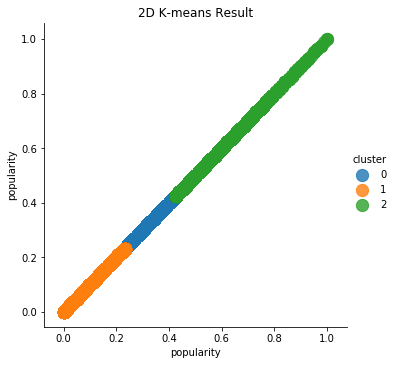

In [12]:
hierarchy1 = songs_1[['popularity']]

# Fit the model.
model = KMeans(n_clusters=3,random_state=10).fit(hierarchy1)

# Get results.
hierarchy1['cluster'] = model.predict(hierarchy1)

# 결과값 살펴보기
hierarchy1['cluster'].unique()

# fit_reg = False는 회귀 옵션 제거, scatter_kws = {"s":50}는 산점도 그래프 점 크기 설정
sb.lmplot('popularity','popularity',data = hierarchy1, fit_reg = False, scatter_kws = {"s":150}, hue = "cluster")
plt.title('2D K-means Result')

In [13]:
# # # 나타난 특성에 따라서 실제 곡들 살펴보기
# hierarchy1=pd.concat([songs['song_name'], hierarchy1], axis=1)
# hierarchy1

In [14]:
# hierarchy1df = pd.DataFrame(hierarchy1)
# hierarchy1df.loc[(hierarchy1df['cluster']==1)&(hierarchy1df['speechiness']>0.6), :]

#### 2 loudness
트랙의 전체 소리 크기 (데시벨 (dB))입니다.     
음량 값은 전체 트랙에서 평균화되며 트랙의 상대적 음량을 비교하는 데 유용합니다.     

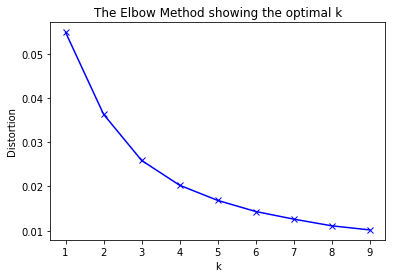

In [15]:
# 최적의 클러스터 갯수 찾기: Elbow Method
distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(hierarchy2)
    kmeanModel.fit(hierarchy2)
    distortions.append(sum(np.min(cdist(hierarchy2, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / hierarchy2.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [16]:
# 최적의 클러스터 갯수 찾기: Silhouette Coefficient(계수가 가장 높은 것이 최적 클러스터 갯수)
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(hierarchy2)
    label = kmeans.labels_
    sil_coeff = silhouette_score(hierarchy2, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    
print("""
--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.6283248150926813
For n_clusters=3, The Silhouette Coefficient is 0.5831735457971926
For n_clusters=4, The Silhouette Coefficient is 0.5477067151228406
For n_clusters=5, The Silhouette Coefficient is 0.5315661952956746
For n_clusters=6, The Silhouette Coefficient is 0.5276637871796089
For n_clusters=7, The Silhouette Coefficient is 0.5305875227215471
For n_clusters=8, The Silhouette Coefficient is 0.5175514532368998
For n_clusters=9, The Silhouette Coefficient is 0.5239805159500566
For n_clusters=10, The Silhouette Coefficient is 0.5258364734902196
""")

For n_clusters=2, The Silhouette Coefficient is 0.6962754387135065
For n_clusters=3, The Silhouette Coefficient is 0.5975371649287224
For n_clusters=4, The Silhouette Coefficient is 0.5557282511344178
For n_clusters=5, The Silhouette Coefficient is 0.5415145371210176
For n_clusters=6, The Silhouette Coefficient is 0.5318595729893194
For n_clusters=7, The Silhouette Coefficient is 0.5261570673209061
For n_clusters=8, The Silhouette Coefficient is 0.5251369326129397
For n_clusters=9, The Silhouette Coefficient is 0.5221376438590039
For n_clusters=10, The Silhouette Coefficient is 0.5203449623974663

--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.6283248150926813
For n_clusters=3, The Silhouette Coefficient is 0.5831735457971926
For n_clusters=4, The Silhouette Coefficient is 0.5477067151228406
For n_clusters=5, The Silhouette Coefficient is 0.5315661952956746
For n_clusters=6, The Silhouette Coefficient is 0.5276637871796089


Text(0.5, 1.0, '2D K-means Result')

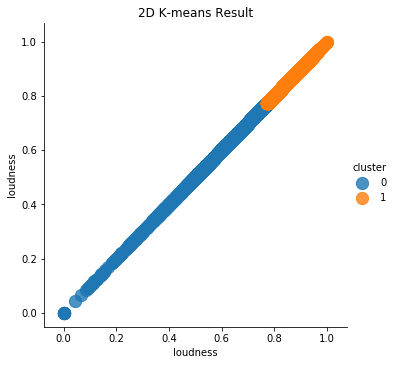

In [17]:
hierarchy2 = songs_1[['loudness']]

# Fit the model.
model = KMeans(n_clusters=2).fit(hierarchy2)

# Get results.
hierarchy2['cluster'] = model.predict(hierarchy2)

# 결과값 살펴보기
hierarchy2['cluster'].unique()

# fit_reg = False는 회귀 옵션 제거, scatter_kws = {"s":50}는 산점도 그래프 점 크기 설정
sb.lmplot('loudness','loudness',data = hierarchy2, fit_reg = False, scatter_kws = {"s":150}, hue = "cluster")
plt.title('2D K-means Result')

#### 3 tempo
분당 비트 수 (BPM)로 트랙의 전체 예상 템포.   

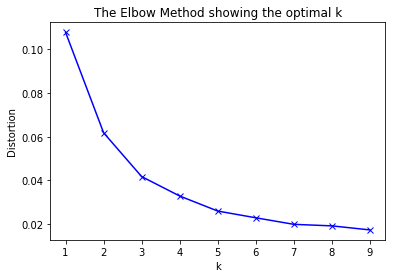

In [18]:
# 최적의 클러스터 갯수 찾기: Elbow Method
distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(hierarchy3)
    kmeanModel.fit(hierarchy3)
    distortions.append(sum(np.min(cdist(hierarchy3, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / hierarchy3.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [19]:
# 최적의 클러스터 갯수 찾기: Silhouette Coefficient(계수가 가장 높은 것이 최적 클러스터 갯수)
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(hierarchy3)
    label = kmeans.labels_
    sil_coeff = silhouette_score(hierarchy3, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    
print("""
--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.5559078591897524
For n_clusters=3, The Silhouette Coefficient is 0.5847977944526075
For n_clusters=4, The Silhouette Coefficient is 0.5662586255868184
For n_clusters=5, The Silhouette Coefficient is 0.5594814665696084
For n_clusters=6, The Silhouette Coefficient is 0.5324077355241575
For n_clusters=7, The Silhouette Coefficient is 0.5485038791541461
For n_clusters=8, The Silhouette Coefficient is 0.5530242374947697
For n_clusters=9, The Silhouette Coefficient is 0.5432055458090275
For n_clusters=10, The Silhouette Coefficient is 0.5352567110622616
""")

For n_clusters=2, The Silhouette Coefficient is 0.5759222628104986
For n_clusters=3, The Silhouette Coefficient is 0.5787947545746738
For n_clusters=4, The Silhouette Coefficient is 0.5364880588114765
For n_clusters=5, The Silhouette Coefficient is 0.5444925990959162
For n_clusters=6, The Silhouette Coefficient is 0.5317129641511327
For n_clusters=7, The Silhouette Coefficient is 0.5328203663544603
For n_clusters=8, The Silhouette Coefficient is 0.5372053103533274
For n_clusters=9, The Silhouette Coefficient is 0.5265142747134941
For n_clusters=10, The Silhouette Coefficient is 0.5302171047193146

--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.5559078591897524
For n_clusters=3, The Silhouette Coefficient is 0.5847977944526075
For n_clusters=4, The Silhouette Coefficient is 0.5662586255868184
For n_clusters=5, The Silhouette Coefficient is 0.5594814665696084
For n_clusters=6, The Silhouette Coefficient is 0.5324077355241575


Text(0.5, 1.0, '2D K-means Result')

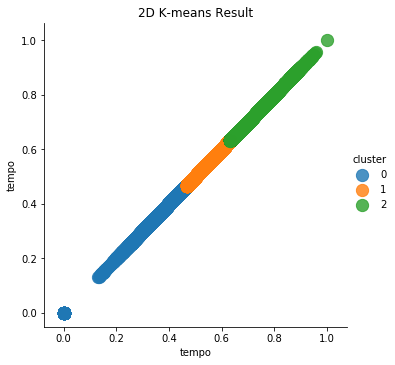

In [20]:
hierarchy3 = songs_1[['tempo']]

# Fit the model.
model = KMeans(n_clusters=3).fit(hierarchy3)

# Get results.
hierarchy3['cluster'] = model.predict(hierarchy3)

# 결과값 살펴보기
hierarchy3['cluster'].unique()

# fit_reg = False는 회귀 옵션 제거, scatter_kws = {"s":50}는 산점도 그래프 점 크기 설정
sb.lmplot('tempo','tempo',data = hierarchy3, fit_reg = False, scatter_kws = {"s":150}, hue = "cluster")
plt.title('2D K-means Result')

#### 4 time_signature
박자

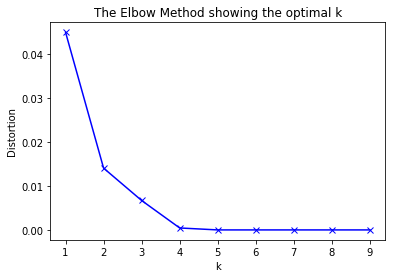

In [21]:
# 최적의 클러스터 갯수 찾기: Elbow Method
distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(hierarchy4)
    kmeanModel.fit(hierarchy4)
    distortions.append(sum(np.min(cdist(hierarchy4, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / hierarchy4.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [22]:
# 최적의 클러스터 갯수 찾기: Silhouette Coefficient(계수가 가장 높은 것이 최적 클러스터 갯수)
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(hierarchy4)
    label = kmeans.labels_
    sil_coeff = silhouette_score(hierarchy4, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    
print("""
--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.9742156057571612
For n_clusters=3, The Silhouette Coefficient is 0.9815542787199448
For n_clusters=4, The Silhouette Coefficient is 0.9998708078931069
For n_clusters=5, The Silhouette Coefficient is 1.0
For n_clusters=6, The Silhouette Coefficient is 1.0
For n_clusters=7, The Silhouette Coefficient is 1.0
For n_clusters=8, The Silhouette Coefficient is 1.0
For n_clusters=9, The Silhouette Coefficient is 1.0
For n_clusters=10, The Silhouette Coefficient is 1.0

""")

For n_clusters=2, The Silhouette Coefficient is 0.954739229643311
For n_clusters=3, The Silhouette Coefficient is 0.9756985831820398
For n_clusters=4, The Silhouette Coefficient is 0.9990767042718608
For n_clusters=5, The Silhouette Coefficient is 1.0
For n_clusters=6, The Silhouette Coefficient is 1.0
For n_clusters=7, The Silhouette Coefficient is 1.0
For n_clusters=8, The Silhouette Coefficient is 1.0
For n_clusters=9, The Silhouette Coefficient is 1.0
For n_clusters=10, The Silhouette Coefficient is 1.0

--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.9742156057571612
For n_clusters=3, The Silhouette Coefficient is 0.9815542787199448
For n_clusters=4, The Silhouette Coefficient is 0.9998708078931069
For n_clusters=5, The Silhouette Coefficient is 1.0
For n_clusters=6, The Silhouette Coefficient is 1.0
For n_clusters=7, The Silhouette Coefficient is 1.0
For n_clusters=8, The Silhouette Coefficient is 1.0
For n_clusters=9,

Text(0.5, 1.0, '2D K-means Result')

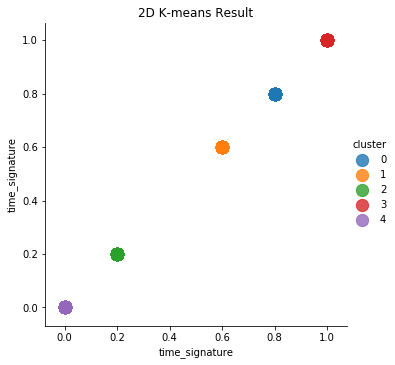

In [23]:
hierarchy4 = songs_1[['time_signature']]

# Fit the model.
model = KMeans(n_clusters=5).fit(hierarchy4)

# Get results.
hierarchy4['cluster'] = model.predict(hierarchy4)

# 결과값 살펴보기
hierarchy4['cluster'].unique()

# fit_reg = False는 회귀 옵션 제거, scatter_kws = {"s":50}는 산점도 그래프 점 크기 설정
sb.lmplot('time_signature','time_signature',data = hierarchy4, fit_reg = False, scatter_kws = {"s":150}, hue = "cluster")
plt.title('2D K-means Result')

#### 5 acousticness
트랙의 음향에서 어쿠스틱 요소 여부에 대해 0.0에서 1.0까지의 특성을 측정.    
1.0은 트랙이 어쿠스틱적이라는 측정.    

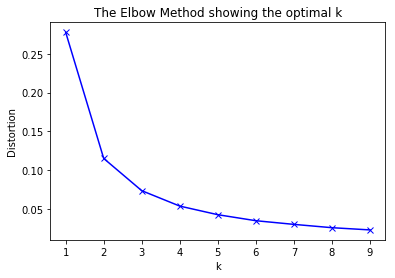

In [24]:
# 최적의 클러스터 갯수 찾기: Elbow Method
distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(hierarchy5)
    kmeanModel.fit(hierarchy5)
    distortions.append(sum(np.min(cdist(hierarchy5, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / hierarchy5.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [25]:
# 최적의 클러스터 갯수 찾기: Silhouette Coefficient(계수가 가장 높은 것이 최적 클러스터 갯수)
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(hierarchy5)
    label = kmeans.labels_
print("""
--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.7231575171382643
    sil_coeff = silhouette_score(hierarchy5, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    
For n_clusters=3, The Silhouette Coefficient is 0.6728928851406547
For n_clusters=4, The Silhouette Coefficient is 0.6515717480964063
For n_clusters=5, The Silhouette Coefficient is 0.6375164183102188
For n_clusters=6, The Silhouette Coefficient is 0.6197537456232791
For n_clusters=7, The Silhouette Coefficient is 0.6143940264152659
For n_clusters=8, The Silhouette Coefficient is 0.6002197880660268
For n_clusters=9, The Silhouette Coefficient is 0.5960973970735999
For n_clusters=10, The Silhouette Coefficient is 0.5960681157818892
""")

For n_clusters=2, The Silhouette Coefficient is 0.7294694125658189
For n_clusters=3, The Silhouette Coefficient is 0.6868043993819828
For n_clusters=4, The Silhouette Coefficient is 0.6620565008440724
For n_clusters=5, The Silhouette Coefficient is 0.6455482660864019
For n_clusters=6, The Silhouette Coefficient is 0.6354247614276801
For n_clusters=7, The Silhouette Coefficient is 0.6269452584012571
For n_clusters=8, The Silhouette Coefficient is 0.6210561307714978
For n_clusters=9, The Silhouette Coefficient is 0.6133284470261603
For n_clusters=10, The Silhouette Coefficient is 0.6081659609276601

--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.7231575171382643
For n_clusters=3, The Silhouette Coefficient is 0.6728928851406547
For n_clusters=4, The Silhouette Coefficient is 0.6515717480964063
For n_clusters=5, The Silhouette Coefficient is 0.6375164183102188
For n_clusters=6, The Silhouette Coefficient is 0.6197537456232791


Text(0.5, 1.0, '2D K-means Result')

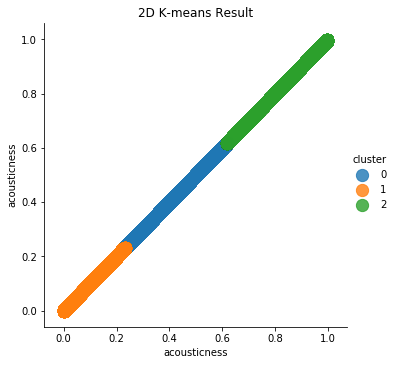

In [26]:
hierarchy5 = songs_1[['acousticness']]

# Fit the model.
model = KMeans(n_clusters=3).fit(hierarchy5)

# Get results.
hierarchy5['cluster'] = model.predict(hierarchy5)

# 결과값 살펴보기
hierarchy5['cluster'].unique()

# fit_reg = False는 회귀 옵션 제거, scatter_kws = {"s":50}는 산점도 그래프 점 크기 설정
sb.lmplot('acousticness','acousticness',data = hierarchy5, fit_reg = False, scatter_kws = {"s":150}, hue = "cluster")
plt.title('2D K-means Result')

#### 6 danceability
곡이 가지는 템포, 리듬의 안정성, 박자 강도 및 전반적인 규칙성을 포함한 음악 요소의 조합에 따라 춤에 적합한 트랙을 설명합니다.    
0.0 부터 1.0까지의 값이 존재하고, 1.0은 가장 무용에 적합합니다.     

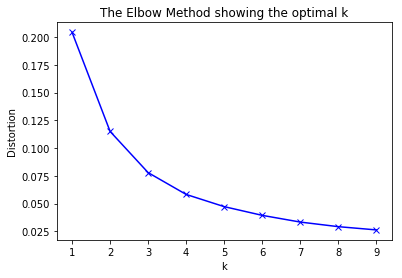

In [27]:
# 최적의 클러스터 갯수 찾기: Elbow Method
distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(hierarchy7)
    kmeanModel.fit(hierarchy7)
    distortions.append(sum(np.min(cdist(hierarchy7, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / hierarchy7.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [28]:
# 최적의 클러스터 갯수 찾기: Silhouette Coefficient(계수가 가장 높은 것이 최적 클러스터 갯수)
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(hierarchy6)
    label = kmeans.labels_
    sil_coeff = silhouette_score(hierarchy6, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    
print("""
--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.5668990922416474
For n_clusters=3, The Silhouette Coefficient is 0.5402227258536184
For n_clusters=4, The Silhouette Coefficient is 0.5319269406024023
For n_clusters=5, The Silhouette Coefficient is 0.5244312184157359
For n_clusters=6, The Silhouette Coefficient is 0.5296495247942999
For n_clusters=7, The Silhouette Coefficient is 0.5227960414489765
For n_clusters=8, The Silhouette Coefficient is 0.5226658081465275
For n_clusters=9, The Silhouette Coefficient is 0.5260552296634247
For n_clusters=10, The Silhouette Coefficient is 0.5284788538834818
""")

For n_clusters=2, The Silhouette Coefficient is 0.5612624917136055
For n_clusters=3, The Silhouette Coefficient is 0.5453678656998164
For n_clusters=4, The Silhouette Coefficient is 0.5325776959565125
For n_clusters=5, The Silhouette Coefficient is 0.5277539197458037
For n_clusters=6, The Silhouette Coefficient is 0.5249880908140754
For n_clusters=7, The Silhouette Coefficient is 0.5225421351842733
For n_clusters=8, The Silhouette Coefficient is 0.5226406626241621
For n_clusters=9, The Silhouette Coefficient is 0.5216683837772546
For n_clusters=10, The Silhouette Coefficient is 0.5184774423702415

--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.5668990922416474
For n_clusters=3, The Silhouette Coefficient is 0.5402227258536184
For n_clusters=4, The Silhouette Coefficient is 0.5319269406024023
For n_clusters=5, The Silhouette Coefficient is 0.5244312184157359
For n_clusters=6, The Silhouette Coefficient is 0.5296495247942999


Text(0.5, 1.0, '2D K-means Result')

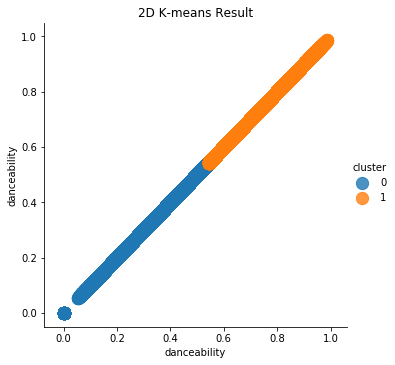

In [29]:
hierarchy6 = songs_1[['danceability']]

# Fit the model.
model = KMeans(n_clusters=2).fit(hierarchy6)

# Get results.
hierarchy6['cluster'] = model.predict(hierarchy6)

# 결과값 살펴보기
hierarchy6['cluster'].unique()

# fit_reg = False는 회귀 옵션 제거, scatter_kws = {"s":50}는 산점도 그래프 점 크기 설정
sb.lmplot('danceability','danceability',data = hierarchy6, fit_reg = False, scatter_kws = {"s":150}, hue = "cluster")
plt.title('2D K-means Result')

#### 7 energy
곡이 얼마나 강렬하고 활동적인지를 측정한 값. 0.0에서 1.0까지 값이 존재.  
이 속성에 기여하는 지각 특징은 동적 범위,인지 된 소리 크기, 음색, 시작 속도 및 일반 엔트로피를 포함합니다.   

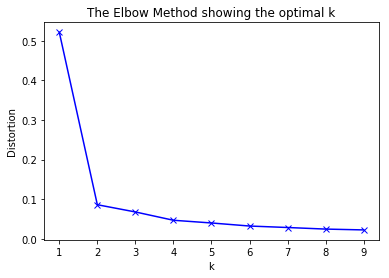

In [30]:
# 최적의 클러스터 갯수 찾기: Elbow Method
distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(hierarchy6)
    kmeanModel.fit(hierarchy6)
    distortions.append(sum(np.min(cdist(hierarchy6, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / hierarchy6.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [31]:
# 최적의 클러스터 갯수 찾기: Silhouette Coefficient(계수가 가장 높은 것이 최적 클러스터 갯수)
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(hierarchy7)
    label = kmeans.labels_
    sil_coeff = silhouette_score(hierarchy7, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    
print("""
--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.5884893241728968
For n_clusters=3, The Silhouette Coefficient is 0.5591569656953753
For n_clusters=4, The Silhouette Coefficient is 0.5540768747848006
For n_clusters=5, The Silhouette Coefficient is 0.5416728263299176
For n_clusters=6, The Silhouette Coefficient is 0.533423732960354
For n_clusters=7, The Silhouette Coefficient is 0.5394039732052476
For n_clusters=8, The Silhouette Coefficient is 0.5346137207027504
For n_clusters=9, The Silhouette Coefficient is 0.5290859226048613
For n_clusters=10, The Silhouette Coefficient is 0.5301602780732029
""")

For n_clusters=2, The Silhouette Coefficient is 0.6008518083637158
For n_clusters=3, The Silhouette Coefficient is 0.5764629485669804
For n_clusters=4, The Silhouette Coefficient is 0.5638909849873192
For n_clusters=5, The Silhouette Coefficient is 0.5528808851851773
For n_clusters=6, The Silhouette Coefficient is 0.5443437475726042
For n_clusters=7, The Silhouette Coefficient is 0.5446665194797399
For n_clusters=8, The Silhouette Coefficient is 0.539103623259708
For n_clusters=9, The Silhouette Coefficient is 0.5392092545396666
For n_clusters=10, The Silhouette Coefficient is 0.53456471240842

--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.5884893241728968
For n_clusters=3, The Silhouette Coefficient is 0.5591569656953753
For n_clusters=4, The Silhouette Coefficient is 0.5540768747848006
For n_clusters=5, The Silhouette Coefficient is 0.5416728263299176
For n_clusters=6, The Silhouette Coefficient is 0.533423732960354
For 

Text(0.5, 1.0, '2D K-means Result')

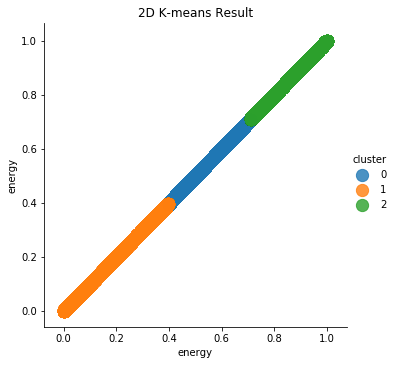

In [32]:
hierarchy7 = songs_1[['energy']]

# Fit the model.
model = KMeans(n_clusters=3).fit(hierarchy7)

# Get results.
hierarchy7['cluster'] = model.predict(hierarchy7)

# 결과값 살펴보기
hierarchy7['cluster'].unique()

# fit_reg = False는 회귀 옵션 제거, scatter_kws = {"s":50}는 산점도 그래프 점 크기 설정
sb.lmplot('energy','energy',data = hierarchy7, fit_reg = False, scatter_kws = {"s":150}, hue = "cluster")
plt.title('2D K-means Result')

#### 8 instrumentalness
트랙에 보컬이 없는지 여부를 예측합니다.    
Instrumentalness 값이 1.0에 가까울수록 트랙에 보컬 콘텐츠가 포함되지 않을 확률이 높아집니다.      

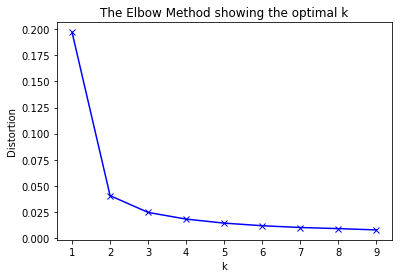

In [33]:
# 최적의 클러스터 갯수 찾기: Elbow Method
distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(hierarchy8)
    kmeanModel.fit(hierarchy8)
    distortions.append(sum(np.min(cdist(hierarchy8, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / hierarchy8.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [34]:
# 최적의 클러스터 갯수 찾기: Silhouette Coefficient(계수가 가장 높은 것이 최적 클러스터 갯수)
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(hierarchy8)
    label = kmeans.labels_
    sil_coeff = silhouette_score(hierarchy8, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    
print("""
--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.9397776192151874
For n_clusters=3, The Silhouette Coefficient is 0.926664775806935
For n_clusters=4, The Silhouette Coefficient is 0.9152855860250588
For n_clusters=5, The Silhouette Coefficient is 0.9074592549587839
For n_clusters=6, The Silhouette Coefficient is 0.905684876566936
For n_clusters=7, The Silhouette Coefficient is 0.8986700619557062
For n_clusters=8, The Silhouette Coefficient is 0.8946821787691638
For n_clusters=9, The Silhouette Coefficient is 0.8893415278240993
For n_clusters=10, The Silhouette Coefficient is 0.8808221477058428
""")

For n_clusters=2, The Silhouette Coefficient is 0.9269949862545479
For n_clusters=3, The Silhouette Coefficient is 0.9120451199516765
For n_clusters=4, The Silhouette Coefficient is 0.8987213022817209
For n_clusters=5, The Silhouette Coefficient is 0.8881440882144185
For n_clusters=6, The Silhouette Coefficient is 0.8790684577276336
For n_clusters=7, The Silhouette Coefficient is 0.873574819075668
For n_clusters=8, The Silhouette Coefficient is 0.8682664939807159
For n_clusters=9, The Silhouette Coefficient is 0.8607466973175838
For n_clusters=10, The Silhouette Coefficient is 0.8593931403938879

--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.9397776192151874
For n_clusters=3, The Silhouette Coefficient is 0.926664775806935
For n_clusters=4, The Silhouette Coefficient is 0.9152855860250588
For n_clusters=5, The Silhouette Coefficient is 0.9074592549587839
For n_clusters=6, The Silhouette Coefficient is 0.905684876566936
For

Text(0.5, 1.0, '2D K-means Result')

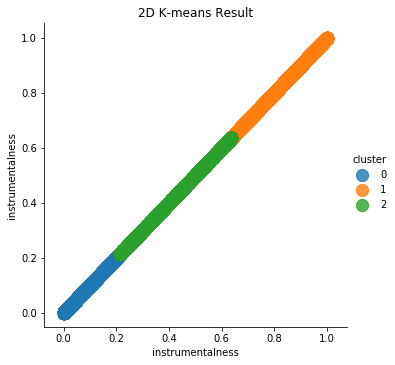

In [35]:
hierarchy8 = songs_1[['instrumentalness']]

# Fit the model.
model = KMeans(n_clusters=3).fit(hierarchy8)

# Get results.
hierarchy8['cluster'] = model.predict(hierarchy8)

# 결과값 살펴보기
hierarchy8['cluster'].unique()

# fit_reg = False는 회귀 옵션 제거, scatter_kws = {"s":50}는 산점도 그래프 점 크기 설정
sb.lmplot('instrumentalness','instrumentalness',data = hierarchy8, fit_reg = False, scatter_kws = {"s":150}, hue = "cluster")
plt.title('2D K-means Result')

#### 9 liveness
0.8보다 큰 값은 트랙이 라이브 트랙일 가능성이 큽니다.

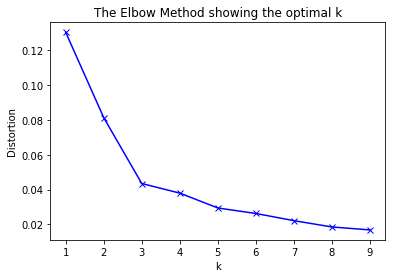

In [36]:
# 최적의 클러스터 갯수 찾기: Elbow Method
distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(hierarchy9)
    kmeanModel.fit(hierarchy9)
    distortions.append(sum(np.min(cdist(hierarchy9, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / hierarchy9.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [11]:
# 최적의 클러스터 갯수 찾기: Silhouette Coefficient(계수가 가장 높은 것이 최적 클러스터 갯수)
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(hierarchy9)
    label = kmeans.labels_
    sil_coeff = silhouette_score(hierarchy9, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    
print("""
--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.7249971789509388
For n_clusters=3, The Silhouette Coefficient is 0.7118731738851806
For n_clusters=4, The Silhouette Coefficient is 0.6328283232402698
For n_clusters=5, The Silhouette Coefficient is 0.6258582750238566
For n_clusters=6, The Silhouette Coefficient is 0.5215925550661045
For n_clusters=7, The Silhouette Coefficient is 0.5274835130050511
For n_clusters=8, The Silhouette Coefficient is 0.5371589905696009
For n_clusters=9, The Silhouette Coefficient is 0.5344829676138343
For n_clusters=10, The Silhouette Coefficient is 0.5336034360459937
""")

For n_clusters=2, The Silhouette Coefficient is 0.7643489597124307
For n_clusters=3, The Silhouette Coefficient is 0.7120722349316502
For n_clusters=4, The Silhouette Coefficient is 0.7020344268181066
For n_clusters=5, The Silhouette Coefficient is 0.6266070569486174
For n_clusters=6, The Silhouette Coefficient is 0.6095397700869678
For n_clusters=7, The Silhouette Coefficient is 0.5480585070209096
For n_clusters=8, The Silhouette Coefficient is 0.5368203929839228
For n_clusters=9, The Silhouette Coefficient is 0.5399411869742752
For n_clusters=10, The Silhouette Coefficient is 0.5419495254286522

--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.7249971789509388
For n_clusters=3, The Silhouette Coefficient is 0.7118731738851806
For n_clusters=4, The Silhouette Coefficient is 0.6328283232402698
For n_clusters=5, The Silhouette Coefficient is 0.6258582750238566
For n_clusters=6, The Silhouette Coefficient is 0.5215925550661045


Text(0.5, 1.0, '2D K-means Result')

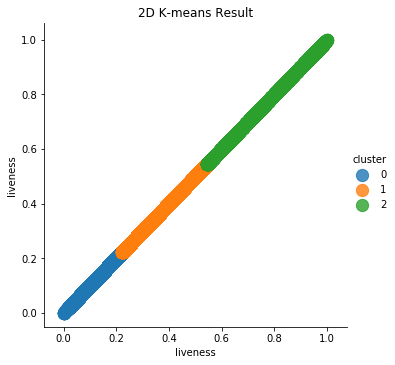

In [12]:
hierarchy9 = songs_1[['liveness']]

# Fit the model.
model = KMeans(n_clusters=3).fit(hierarchy9)

# Get results.
hierarchy9['cluster'] = model.predict(hierarchy9)

# 결과값 살펴보기
hierarchy9['cluster'].unique()

# fit_reg = False는 회귀 옵션 제거, scatter_kws = {"s":50}는 산점도 그래프 점 크기 설정
sb.lmplot('liveness','liveness',data = hierarchy9, fit_reg = False, scatter_kws = {"s":150}, hue = "cluster")
plt.title('2D K-means Result')

#### 10 speechiness
Speechiness는 트랙에서 말한 단어의 존재를 감지합니다.    
0.66 이상의 값은 전적으로 음성 단어로 만들어진 트랙을 나타냅니다.      
0.33에서 0.66 사이의 값은 랩 음악과 같은 경우를 포함하여 섹션 또는 계층으로 음악과 음성을 모두 포함 할 수있는 트랙을 나타냅니다.     
0.33 미만의 값은 음악 및 기타 비언 연적 트랙을 나타낼 가능성이 가장 높습니다.     

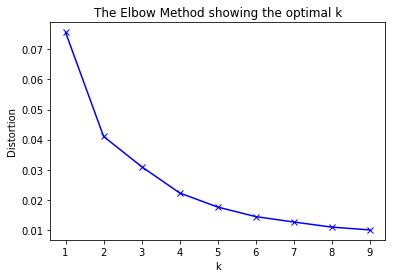

In [13]:
# 최적의 클러스터 갯수 찾기: Elbow Method
distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(hierarchy10)
    kmeanModel.fit(hierarchy10)
    distortions.append(sum(np.min(cdist(hierarchy10, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / hierarchy10.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [14]:
# 최적의 클러스터 갯수 찾기: Silhouette Coefficient(계수가 가장 높은 것이 최적 클러스터 갯수)
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(hierarchy10)
    label = kmeans.labels_
    sil_coeff = silhouette_score(hierarchy10, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    
print("""
--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.9536883218365044
For n_clusters=3, The Silhouette Coefficient is 0.9055975843553611
For n_clusters=4, The Silhouette Coefficient is 0.7000378575276186
For n_clusters=5, The Silhouette Coefficient is 0.6982522162667526
For n_clusters=6, The Silhouette Coefficient is 0.6954219611969468
For n_clusters=7, The Silhouette Coefficient is 0.6334627063237654
For n_clusters=8, The Silhouette Coefficient is 0.6261900329940658
For n_clusters=9, The Silhouette Coefficient is 0.5957724185602594
For n_clusters=10, The Silhouette Coefficient is 0.5968445803972106

""")

For n_clusters=2, The Silhouette Coefficient is 0.8089257593464313
For n_clusters=3, The Silhouette Coefficient is 0.8014700959139541
For n_clusters=4, The Silhouette Coefficient is 0.7392497896567619
For n_clusters=5, The Silhouette Coefficient is 0.7011693664589029
For n_clusters=6, The Silhouette Coefficient is 0.6687066094816982
For n_clusters=7, The Silhouette Coefficient is 0.6493659848636042
For n_clusters=8, The Silhouette Coefficient is 0.626677583246078
For n_clusters=9, The Silhouette Coefficient is 0.6108418958081664
For n_clusters=10, The Silhouette Coefficient is 0.593669843579409

--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.9536883218365044
For n_clusters=3, The Silhouette Coefficient is 0.9055975843553611
For n_clusters=4, The Silhouette Coefficient is 0.7000378575276186
For n_clusters=5, The Silhouette Coefficient is 0.6982522162667526
For n_clusters=6, The Silhouette Coefficient is 0.6954219611969468
Fo

Text(0.5, 1.0, '2D K-means Result')

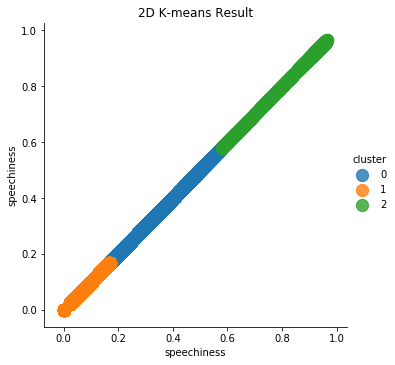

In [15]:
hierarchy10 = songs_1[['speechiness']]

# Fit the model.
model = KMeans(n_clusters=3).fit(hierarchy10)

# Get results.
hierarchy10['cluster'] = model.predict(hierarchy10)

# 결과값 살펴보기
hierarchy10['cluster'].unique()

# fit_reg = False는 회귀 옵션 제거, scatter_kws = {"s":50}는 산점도 그래프 점 크기 설정
sb.lmplot('speechiness','speechiness',data = hierarchy10, fit_reg = False, scatter_kws = {"s":150}, hue = "cluster")
plt.title('2D K-means Result')

#### 11 audio_valence
높은 원자가를 가진 트랙은 긍정적 (예 : 행복, 쾌활, 행복),    
낮은 원자가의 트랙은 더 부정적 (예 : 슬프고 우울, 분노)

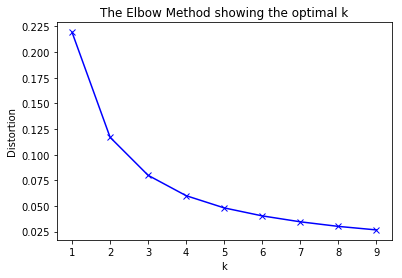

In [16]:
# 최적의 클러스터 갯수 찾기: Elbow Method
distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(hierarchy11)
    kmeanModel.fit(hierarchy11)
    distortions.append(sum(np.min(cdist(hierarchy11, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / hierarchy11.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [17]:
# 최적의 클러스터 갯수 찾기: Silhouette Coefficient(계수가 가장 높은 것이 최적 클러스터 갯수)
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(hierarchy11)
    label = kmeans.labels_
    sil_coeff = silhouette_score(hierarchy11, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    
print("""
--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.5998756091612572
For n_clusters=3, The Silhouette Coefficient is 0.5657108996263202
For n_clusters=4, The Silhouette Coefficient is 0.5505145892187246
For n_clusters=5, The Silhouette Coefficient is 0.5479664165245922
For n_clusters=6, The Silhouette Coefficient is 0.5391770085006381
For n_clusters=7, The Silhouette Coefficient is 0.5397842932229925
For n_clusters=8, The Silhouette Coefficient is 0.5392455264917894
For n_clusters=9, The Silhouette Coefficient is 0.535083430815819
For n_clusters=10, The Silhouette Coefficient is 0.5334898447054474
""")

For n_clusters=2, The Silhouette Coefficient is 0.6038691000875359
For n_clusters=3, The Silhouette Coefficient is 0.5670658723482085
For n_clusters=4, The Silhouette Coefficient is 0.5581618356730114
For n_clusters=5, The Silhouette Coefficient is 0.5503768290998844
For n_clusters=6, The Silhouette Coefficient is 0.5428278453555995
For n_clusters=7, The Silhouette Coefficient is 0.5409920376906932
For n_clusters=8, The Silhouette Coefficient is 0.5408226534429205
For n_clusters=9, The Silhouette Coefficient is 0.5380406933771622
For n_clusters=10, The Silhouette Coefficient is 0.5383664405084335

--------------------------2만개 data 결과----------------------
For n_clusters=2, The Silhouette Coefficient is 0.5998756091612572
For n_clusters=3, The Silhouette Coefficient is 0.5657108996263202
For n_clusters=4, The Silhouette Coefficient is 0.5505145892187246
For n_clusters=5, The Silhouette Coefficient is 0.5479664165245922
For n_clusters=6, The Silhouette Coefficient is 0.5391770085006381


Text(0.5, 1.0, '2D K-means Result')

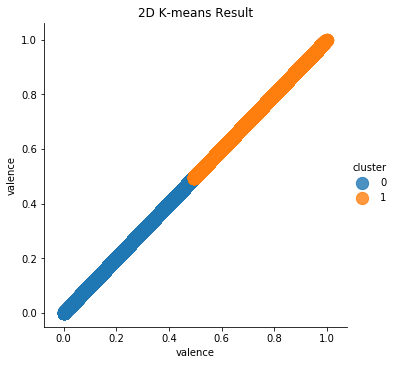

In [18]:
hierarchy11 = songs_1[['valence']]

# Fit the model.
model = KMeans(n_clusters=2).fit(hierarchy11)

# Get results.
hierarchy11['cluster'] = model.predict(hierarchy11)

# 결과값 살펴보기
hierarchy11['cluster'].unique()

# fit_reg = False는 회귀 옵션 제거, scatter_kws = {"s":50}는 산점도 그래프 점 크기 설정
sb.lmplot('valence','valence',data = hierarchy11, fit_reg = False, scatter_kws = {"s":150}, hue = "cluster")
plt.title('2D K-means Result')

#### 12 KEY
곡의 키를 나타내줌 . 범주형

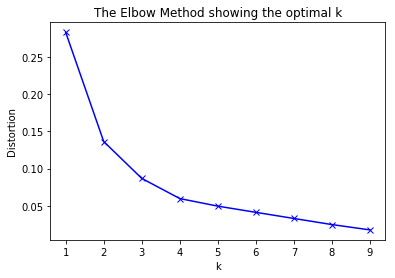

In [19]:
# 최적의 클러스터 갯수 찾기: Elbow Method
distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(hierarchy12)
    kmeanModel.fit(hierarchy12)
    distortions.append(sum(np.min(cdist(hierarchy12, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / hierarchy12.shape[0])
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [20]:
# 최적의 클러스터 갯수 찾기: Silhouette Coefficient(계수가 가장 높은 것이 최적 클러스터 갯수)
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(hierarchy12)
    label = kmeans.labels_
    sil_coeff = silhouette_score(hierarchy12, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))
    
print("""

""")

For n_clusters=2, The Silhouette Coefficient is 0.6500338764466757
For n_clusters=3, The Silhouette Coefficient is 0.6505139942200704
For n_clusters=4, The Silhouette Coefficient is 0.662160050641121
For n_clusters=5, The Silhouette Coefficient is 0.6737275584405801
For n_clusters=6, The Silhouette Coefficient is 0.7051009273030128
For n_clusters=7, The Silhouette Coefficient is 0.7623485626618655
For n_clusters=8, The Silhouette Coefficient is 0.7715904994500151
For n_clusters=9, The Silhouette Coefficient is 0.8235221338042692
For n_clusters=10, The Silhouette Coefficient is 0.896387319754205





Text(0.5, 1.0, '2D K-means Result')

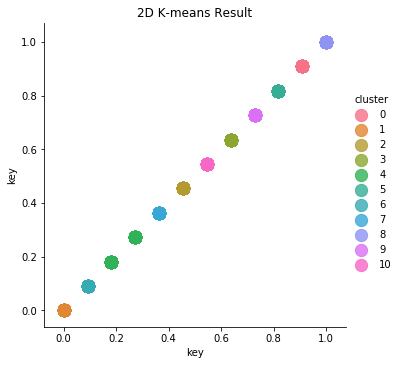

In [21]:
hierarchy11 = songs_1[['key']]

# Fit the model.
model = KMeans(n_clusters=11).fit(hierarchy12)

# Get results.
hierarchy12['cluster'] = model.predict(hierarchy12)

# 결과값 살펴보기
hierarchy12['cluster'].unique()

# fit_reg = False는 회귀 옵션 제거, scatter_kws = {"s":50}는 산점도 그래프 점 크기 설정
sb.lmplot('key','key',data = hierarchy12, fit_reg = False, scatter_kws = {"s":150}, hue = "cluster")
plt.title('2D K-means Result')

## 군집화 방식을 여러가지로 시도해보기
< 변수가 될만한 것 >
1. 표준화 여부
DURATION 칼럼의 경우 값이 너무 크게 나오므로 이 값에 따라 군집이 좌지우지 될 가능성이 높다.
군집화에 있어서 표준화를 시키는 것이 어떻게 영향을 미치는지 실행해 보자.

2. 계층적으로 군집화
계층적으로 군집화를 진행할때 가장 큰 분류를 먼저 하는 것 부터 작은 요소들을 분류하는 것으로 생각해 보아야 할 것 같다.

>MBTI 방식의 분류 방법을 적용 칼럼별 분류를 적용




